# FNN on MNIST with missing 7
Here I excluded images labeled 7 from the train data, and use those label '7' images for test data. To see how the model will behave when it has not seen any 7 images.

The train scores is approaching 100%, and test accuracy is 0. Which makes sense because the model has never seen '7' and will not predict 7.

To analyze what the model think 7 is, I plotted a histogram of what the model predicts with '7' images. Looks like it mostly predict it to be 9. Which makes sense because 9 is close to 7 in shape. 

In [1]:
# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
# display.set_matplotlib_formats('svg')

# Import and process the data

In [3]:
# import dataset (comes with colab!)
with open('/Users/alexchen/Downloads/mnist/mnist_test.csv','rb') as f:
   data = np.loadtxt(f, delimiter=',', skiprows=1)
# extract labels (number IDs) and remove from data

# get non-label 7 for train data, and label 7 rows as test data.
data_train = data[data[:, 0] != 7]
data_test = data[data[:, 0] == 7]

labels_train = data_train[:,0]
data_train   = data_train[:,1:]

labels_test = data_test[:,0]
data_test   = data_test[:,1:]


In [4]:
# normalize the data to a range of [0 1]
dataNorm_train = data_train / np.max(data)
dataNorm_test = data_test / np.max(data)


# Create train/test groups using DataLoader

In [5]:
# Step 1: convert to tensor
train_data   = torch.tensor( dataNorm_train ).float()
train_labels = torch.tensor( labels_train ).long() # long = int64

test_data   = torch.tensor( dataNorm_test ).float()
test_labels = torch.tensor( labels_test ).long() # long = int64

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [6]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [7]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.softmax(yHat, axis=1))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3098, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [8]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [9]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()


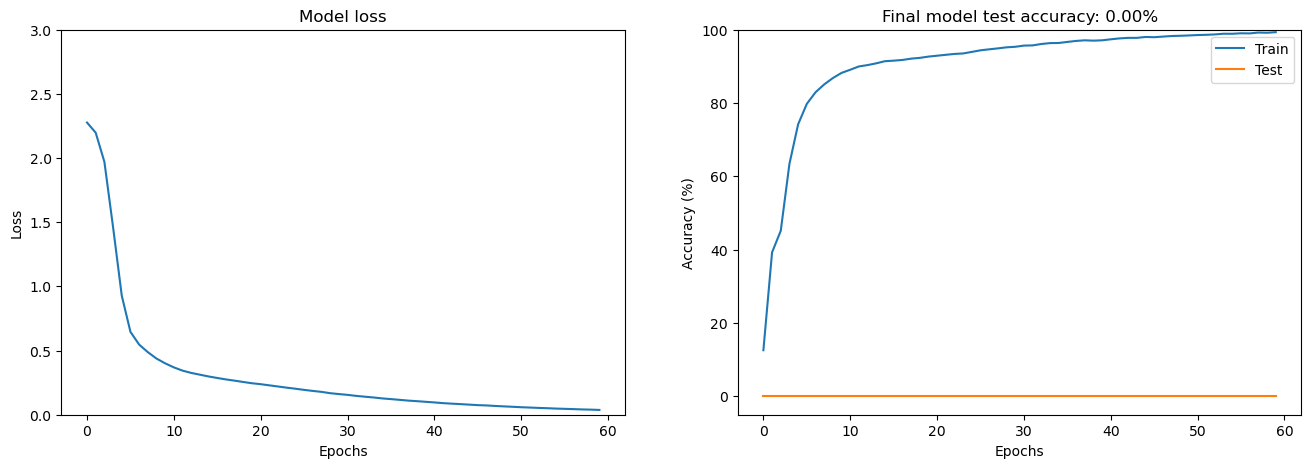

In [10]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([-5,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect what the model think 7 is

Text(0.5, 1.0, 'What the model predicts for label 7 images without training on them')

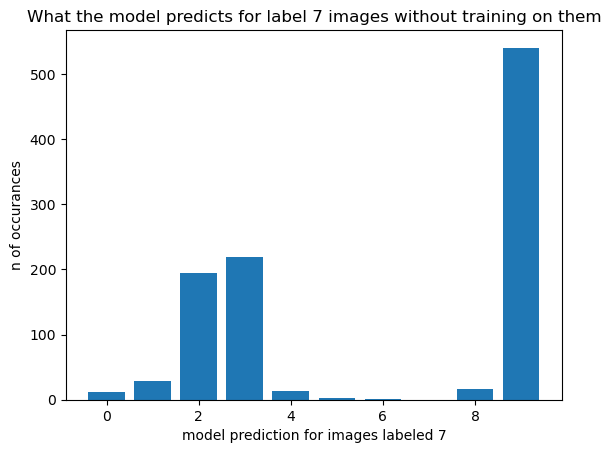

In [14]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

unique_counts = np.unique(torch.argmax(predictions, axis = 1).numpy(), return_counts=True)
plt.bar(unique_counts[0], unique_counts[1])
plt.xlabel('model prediction for images labeled 7')
plt.ylabel('n of occurances')
plt.title('What the model predicts for label 7 images without training on them')